Functions on winning_chances.py:

0. `convert_evaluation(row)`
1. `calculate_chances(df, lower_eval, upper_eval)`
2. `compute_winning_chance_table(df, intervals=np.arange(-13, 13.2, 0.2))`
3. `process_chess_data(df, winning_chance_table=pd.read_csv('winning_chances_all_moves.csv'), intervals=np.arange(-13, 13.2, 0.2))`
4. `create_summary_table(df, mistake_bins= [5, 10, 15, 20, 25, 30, 35, 40, 50, 60, 70, 100], winning_chance_table=None, intervals=None)`

In [10]:
import winning_chances_util
import winning_chances
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
pd.set_option('display.max_columns', None)

In [11]:
mistake_bins = [5, 10, 15, 20, 25, 30, 35, 40, 50, 60, 70, 100]

#df=pd.read_csv("../huge_analyzed_games/combined_analyzed_games_20.csv")

#table=winning_chances.compute_winning_chance_table(df)

#table=pd.read_csv("winning_chances_all_moves.csv")
#summary_table=winning_chances.create_summary_table(df,mistake_bins=mistake_bins,winning_chance_table=table)


#summary_table=pd.read_csv("big_summary_table.csv")

summary_table=pd.read_csv("summary_table_20.csv")

In [72]:
summary_table.to_csv("summary_table_20.csv")

In [4]:
top_100_openings = summary_table['Opening'].value_counts().nlargest(70).index.tolist()
summary_table['Opening'] = summary_table['Opening'].apply(lambda x: x if x in top_100_openings else 'Other')

new_summary_table = summary_table[summary_table['Player'] == 'White'].copy()
new_summary_table = new_summary_table[ (new_summary_table['TotalMoves'] <= 60)]
# Define categorical features to process
start_index = new_summary_table.columns.get_loc('AWCL') + 1
mistake_labels = list(new_summary_table.columns[start_index:])

categorical_features = [ 'Opening', 'Result' ]
#numerical_features=mistake_labels + ['WeightedMistakeScore']
numerical_features=mistake_labels +['AWCL']

# Define total moves bins and create total moves labels
total_moves_bins = [0, 40,  60,  80,  100, 120, np.inf]
total_moves_labels = [
    f'({total_moves_bins[i]},{total_moves_bins[i+1]}]' if not np.isinf(total_moves_bins[i + 1]) else f'({total_moves_bins[i]},∞]'
    for i in range(len(total_moves_bins) - 1)
]

# Create 'TotalMovesInterval' using pd.cut
new_summary_table['TotalMovesInterval'] = pd.cut(
    new_summary_table['TotalMoves'],
    bins=total_moves_bins,
    labels=total_moves_labels,
    right=True,
    include_lowest=True
)

# Handle missing values in the target variable
new_summary_table = new_summary_table.dropna(subset=['Elo'])


# Process categorical features
for col in categorical_features:
    # Convert to 'category' dtype
    new_summary_table[col] = new_summary_table[col].astype('category')
    # Add 'Unknown' to categories if not present
    if 'Unknown' not in new_summary_table[col].cat.categories:
        new_summary_table[col] = new_summary_table[col].cat.add_categories(['Unknown'])
    # Fill NaN values with 'Unknown'
    new_summary_table[col] = new_summary_table[col].fillna('Unknown')

# Handle missing values in numerical features (mistake intervals)
new_summary_table[numerical_features] = new_summary_table[numerical_features].fillna(0)

# Define target variable
y = new_summary_table['Elo']

# Define features
X = new_summary_table[categorical_features + numerical_features]

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=40
)

# Create a ColumnTransformer to apply OneHotEncoder to categorical features
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ],
    remainder='passthrough'  # Pass through numerical features unchanged
)

# Create a pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

# Train the model
pipeline.fit(X_train, y_train)

# Predict and evaluate
y_pred = pipeline.predict(X_test)

# Calculate evaluation metrics
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f'Root Mean Squared Error (RMSE): {rmse:.2f}')
print(f'R-squared Score (R²): {r2:.2f}')

# Calculate percentage of predictions within a threshold
absolute_errors = np.abs(y_pred - y_test)
threshold = 300
within_threshold = np.sum(absolute_errors <= threshold)
total_predictions = len(y_test)
percentage_within_threshold = (within_threshold / total_predictions) * 100

print(f"Percentage of predictions within ±{threshold} Elo: {percentage_within_threshold:.2f}%")




# Get the names of the categorical features after one-hot encoding
onehot_feature_names = pipeline.named_steps['preprocessor'].named_transformers_['cat'].get_feature_names_out(categorical_features)

# Combine with numerical feature names
all_feature_names = np.concatenate([onehot_feature_names, numerical_features])
coefficients = pipeline.named_steps['regressor'].coef_

# Create a DataFrame to display feature names and their coefficients
coef_df = pd.DataFrame({
    'Feature': all_feature_names,
    'Coefficient': coefficients
})

# Sort the coefficients by absolute value
coef_df['AbsCoefficient'] = coef_df['Coefficient'].abs()
coef_df = coef_df.sort_values(by='AbsCoefficient', ascending=False)

# Display the top 5 features with the highest absolute coefficients
print("\nTop 5 features by absolute coefficient value:")
print(coef_df[['Feature', 'Coefficient']].head(5))

mistake_coef_df = coef_df[coef_df['Feature'].isin(mistake_labels)]

# Display the coefficients for the mistake features
print("\nCoefficients for the mistake labels:")
print(mistake_coef_df[['Feature', 'Coefficient']])

Root Mean Squared Error (RMSE): 264.50
R-squared Score (R²): 0.18
Percentage of predictions within ±300 Elo: 76.75%

Top 5 features by absolute coefficient value:
                         Feature  Coefficient
69   Opening_Two knights defence  -251.201825
61  Opening_Scandinavian defence  -176.200208
47   Opening_Queen's bishop game  -158.435322
43      Opening_QGD Slav defence   156.943681
84                      (70,100]   155.638749

Coefficients for the mistake labels:
     Feature  Coefficient
84  (70,100]   155.638749
82   (50,60]    93.164139
80   (35,40]    44.177559
83   (60,70]    35.245889
81   (40,50]    29.204807
79   (30,35]    26.110540
78   (25,30]    15.495465
77   (20,25]    11.021573
76   (15,20]     5.271538
74    (5,10]     4.811553
75   (10,15]    -1.683303


In [8]:
y_pred.min()

1419.8810230738613

In [86]:
# Step 1: Create a dictionary of mistake coefficients
mistake_coefficients = mistake_coef_df.set_index('Feature')['Coefficient'].to_dict()

# Normalize the coefficients so that the sum of their absolute values is 1
total_weight = sum(abs(coef) for coef in mistake_coefficients.values())
normalized_coefficients = {k: abs(v) / total_weight for k, v in mistake_coefficients.items()}

# Step 2: Compute WeightedMistakeScore using normalized coefficients
new_summary_table['WeightedMistakeScore'] = 0.0
for label in mistake_labels:
    coefficient = normalized_coefficients.get(label, 0)
    new_summary_table['WeightedMistakeScore'] += new_summary_table[label] * coefficient


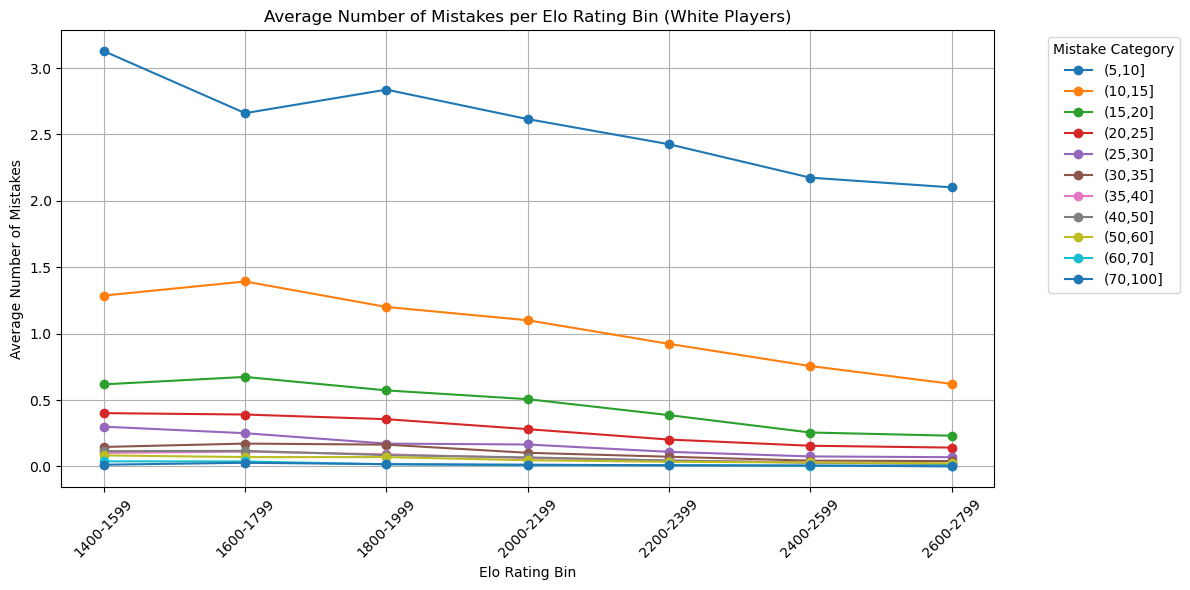

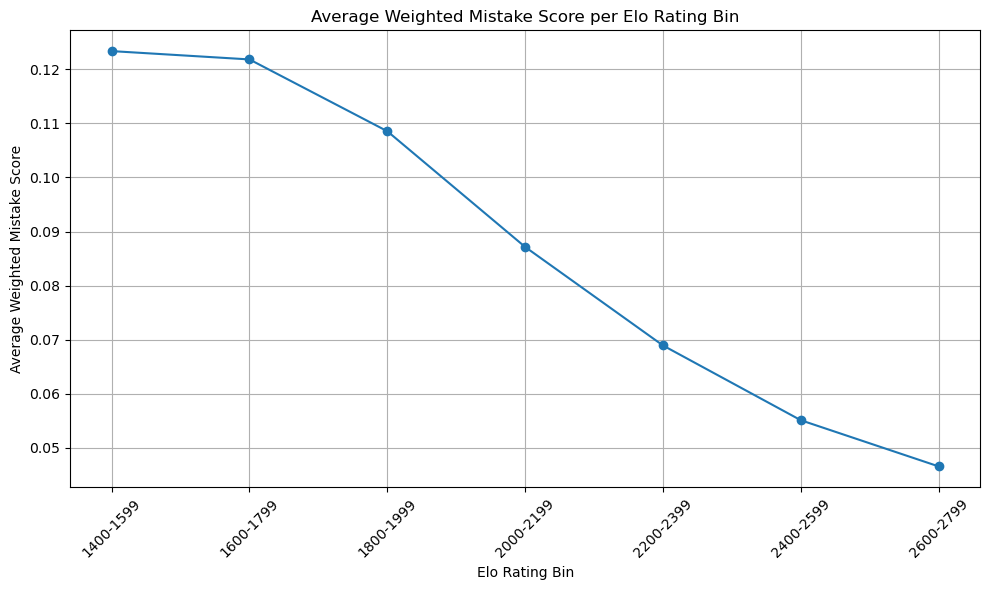

In [87]:
elo_bins = [1400, 1600, 1800, 2000, 2200, 2400, 2600, 2800]

elo_labels = []
for i in range(len(elo_bins) - 1):
    lower = elo_bins[i]
    upper = elo_bins[i + 1]
    if np.isinf(upper):
        label = f'{int(lower)}+'
    else:
        upper = upper - 1  # Subtract 1 to make the upper limit inclusive
        label = f'{int(lower)}-{int(upper)}'
    elo_labels.append(label)

# Assign Elo bins to the data
new_summary_table.loc[:, 'EloBin'] = pd.cut(
    new_summary_table['Elo'],
    bins=elo_bins,
    labels=elo_labels,
    right=True,
    include_lowest=True
)

# Remove rows with missing 'EloBin' values
new_summary_table = new_summary_table.dropna(subset=['EloBin'])

# Step 2: Aggregate the Data
# Group by EloBin and calculate the average number of mistakes in each category
avg_mistakes_per_bin = new_summary_table.groupby('EloBin', observed=False)[mistake_labels].mean().reset_index()

# Step 3: Plot the Data
# Set up the plot
plt.figure(figsize=(12, 6))

# Plot a line for each mistake category
for label in mistake_labels:
    plt.plot(
        avg_mistakes_per_bin['EloBin'],
        avg_mistakes_per_bin[label],
        marker='o',
        label=label
    )

# Customize the plot
plt.title('Average Number of Mistakes per Elo Rating Bin (White Players)')
plt.xlabel('Elo Rating Bin')
plt.ylabel('Average Number of Mistakes')
plt.xticks(rotation=45)
plt.legend(title='Mistake Category', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

# Assuming 'new_summary_table', 'mistake_labels', and 'mistake_coef_df' are already defined


# Step 3: Create Elo bins and labels
elo_bins = [1400, 1600, 1800, 2000, 2200, 2400, 2600, 2800]
elo_labels = []
for i in range(len(elo_bins) - 1):
    lower = elo_bins[i]
    upper = elo_bins[i + 1] - 1  # Subtract 1 to make the upper limit inclusive
    label = f'{int(lower)}-{int(upper)}'
    elo_labels.append(label)
# Assign Elo bins to the data
new_summary_table['EloBin'] = pd.cut(
    new_summary_table['Elo'],
    bins=elo_bins,
    labels=elo_labels,
    right=False  # Left-inclusive intervals
)

# Compute average WeightedMistakeScore per Elo bin
avg_mistake_per_elo_bin = new_summary_table.groupby('EloBin', observed=False)['WeightedMistakeScore'].mean().reset_index()


# Plot the line graph connecting the averages
plt.figure(figsize=(10, 6))
plt.plot(avg_mistake_per_elo_bin['EloBin'], avg_mistake_per_elo_bin['WeightedMistakeScore'], marker='o')
plt.title('Average Weighted Mistake Score per Elo Rating Bin')
plt.xlabel('Elo Rating Bin')
plt.ylabel('Average Weighted Mistake Score')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


In [65]:

# Define categorical features to process

categorical_features = [  'Opening']
numerical_features= [ 'WeightedMistakeScore','AWCL']


# Define target variable
y = new_summary_table['Elo']

# Define features
X = new_summary_table[categorical_features + numerical_features]

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=40
)

# Create a ColumnTransformer to apply OneHotEncoder to categorical features
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ],
    remainder='passthrough'  # Pass through numerical features unchanged
)

# Create a pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

# Train the model
pipeline.fit(X_train, y_train)

# Predict and evaluate
y_pred = pipeline.predict(X_test)

# Calculate evaluation metrics
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f'Root Mean Squared Error (RMSE): {rmse:.2f}')
print(f'R-squared Score (R²): {r2:.2f}')

# Calculate percentage of predictions within a threshold
absolute_errors = np.abs(y_pred - y_test)
threshold = 300
within_threshold = np.sum(absolute_errors <= threshold)
total_predictions = len(y_test)
percentage_within_threshold = (within_threshold / total_predictions) * 100

print(f"Percentage of predictions within ±{threshold} Elo: {percentage_within_threshold:.2f}%")






Root Mean Squared Error (RMSE): 253.96
R-squared Score (R²): 0.06
Percentage of predictions within ±300 Elo: 77.35%


In [35]:
y_pred.max()

2554.9526664461837

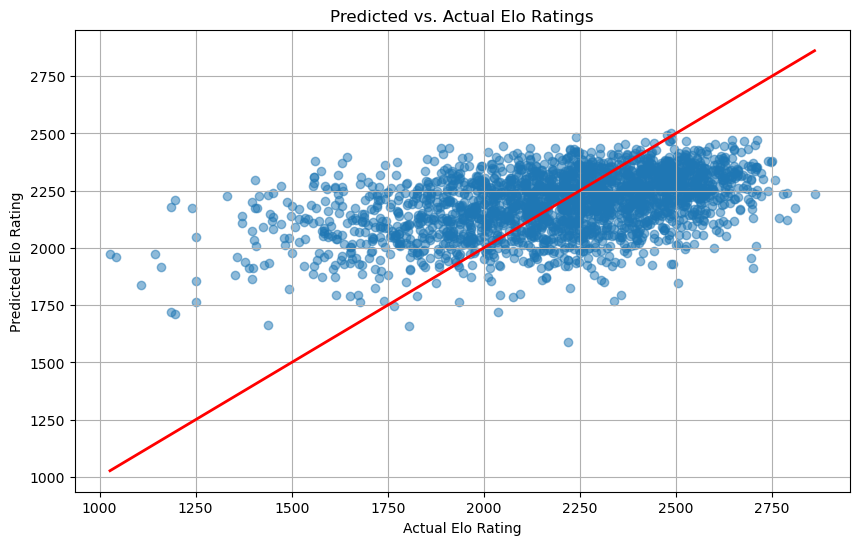

In [78]:

# Plot Predicted vs. Actual Elo Ratings
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r', linewidth=2)
plt.title('Predicted vs. Actual Elo Ratings')
plt.xlabel('Actual Elo Rating')
plt.ylabel('Predicted Elo Rating')
plt.grid(True)
plt.show()


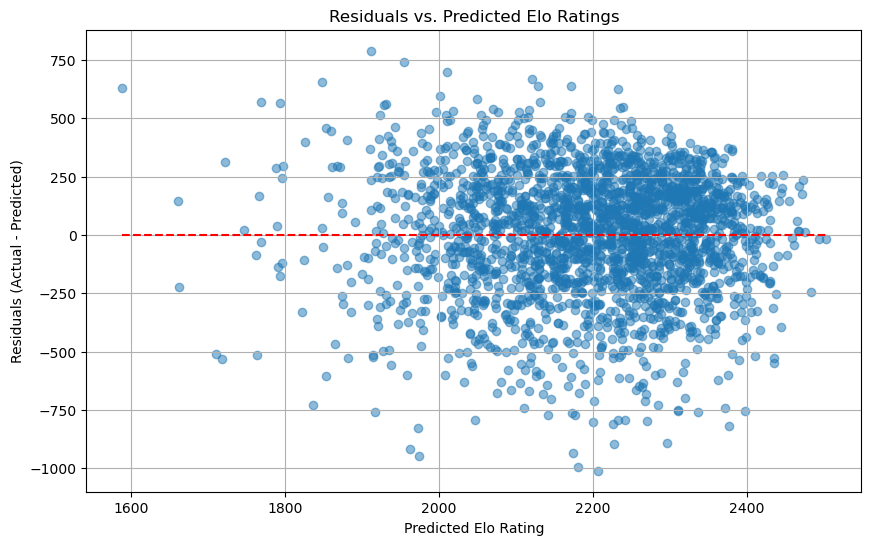

In [79]:
# Calculate residuals
residuals = y_test - y_pred

# Plot Residuals vs. Predicted Elo Ratings
plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals, alpha=0.5)
plt.hlines(0, y_pred.min(), y_pred.max(), colors='r', linestyles='dashed')
plt.title('Residuals vs. Predicted Elo Ratings')
plt.xlabel('Predicted Elo Rating')
plt.ylabel('Residuals (Actual - Predicted)')
plt.grid(True)
plt.show()


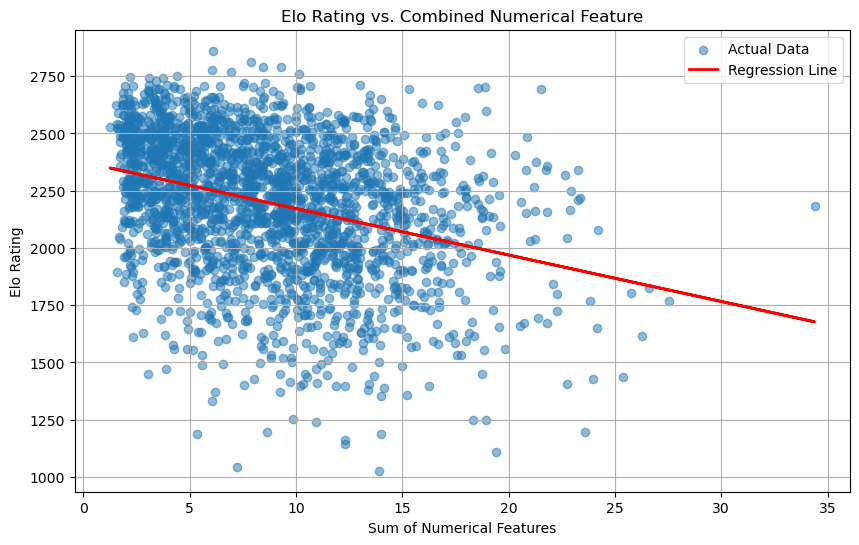

In [80]:
# Combine numerical features into a single feature
X_combined = X[numerical_features].sum(axis=1)
# Reshape X_combined for model fitting
X_combined_reshaped = X_combined.values.reshape(-1, 1)

# Split the combined data
X_train_combined, X_test_combined, y_train_combined, y_test_combined = train_test_split(
    X_combined_reshaped, y, test_size=0.2, random_state=40
)

# Create and train a new linear regression model
model_combined = LinearRegression()
model_combined.fit(X_train_combined, y_train_combined)
# Predict using the combined feature
y_pred_combined = model_combined.predict(X_test_combined)

# Plot the data points and the regression line
plt.figure(figsize=(10, 6))
plt.scatter(X_test_combined, y_test_combined, alpha=0.5, label='Actual Data')
plt.plot(X_test_combined, y_pred_combined, color='red', linewidth=2, label='Regression Line')
plt.title('Elo Rating vs. Combined Numerical Feature')
plt.xlabel('Sum of Numerical Features')
plt.ylabel('Elo Rating')
plt.legend()
plt.grid(True)
plt.show()


In [35]:
player_games=  new_summary_table[(new_summary_table['Elo'] >= 1400) & (new_summary_table['Elo'] <= 1800)]
len(player_games)

548

In [9]:

#player_fide_id = 2020009 
#player_games = new_summary_table[new_summary_table['FideId'] == player_fide_id].copy()

player_games=  new_summary_table[(new_summary_table['Elo'] >= 2500)]

# Select 20 games
player_games = player_games.head(20)

X_player_games = player_games[categorical_features + numerical_features].copy()

# Process categorical features
for col in categorical_features:
    X_player_games[col] = X_player_games[col].astype('category')
    if 'Unknown' not in X_player_games[col].cat.categories:
        X_player_games[col] = X_player_games[col].cat.add_categories(['Unknown'])
    X_player_games[col] = X_player_games[col].fillna('Unknown')

# Handle missing values in numerical features
X_player_games[numerical_features] = X_player_games[numerical_features].fillna(0)

# Predict
y_pred_player = pipeline.predict(X_player_games)

# Print the predictions
for i, pred in enumerate(y_pred_player):
    print(f"Game {i+1} predicted Elo: {pred:.2f}")

# Print the average of the predictions
average_pred = y_pred_player.mean()
print(f"Average predicted Elo: {average_pred:.2f}")


Game 1 predicted Elo: 2319.10
Game 2 predicted Elo: 2199.55
Game 3 predicted Elo: 2325.74
Game 4 predicted Elo: 2370.33
Game 5 predicted Elo: 2343.68
Game 6 predicted Elo: 2314.76
Game 7 predicted Elo: 2284.84
Game 8 predicted Elo: 2015.06
Game 9 predicted Elo: 2078.78
Game 10 predicted Elo: 2057.04
Game 11 predicted Elo: 2273.93
Game 12 predicted Elo: 2336.20
Game 13 predicted Elo: 2426.48
Game 14 predicted Elo: 2260.48
Game 15 predicted Elo: 2321.10
Game 16 predicted Elo: 2523.21
Game 17 predicted Elo: 2327.74
Game 18 predicted Elo: 2242.76
Game 19 predicted Elo: 2218.61
Game 20 predicted Elo: 2343.25
Average predicted Elo: 2279.13


In [55]:
X_player_games.head()

,WeightedMistakeScore
1668,0.578073
1686,0.420587
1704,0.531628
1741,0.996953
1759,0.661477


In [49]:
player_games.head()

,GameID,Player,Name,Elo,FideId,Opening,Variation,Result,TotalMoves,TotalMovesInterval,...,"(20,25]","(25,30]","(30,35]","(35,40]","(40,50]","(50,60]","(60,70]","(70,100]",WeightedMistakeScore,EloBin
1668,875.0,White,"Rotaru,Valentina",1497.0,13905546.0,King's Indian,Larsen variation,0-1,78.0,"(60,80]",...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.578073,1400-1599
1686,884.0,White,"Rotaru,Valentina",1497.0,13905546.0,King's Indian,London system,1/2-1/2,67.0,"(60,80]",...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.420587,1400-1599
1704,893.0,White,"Rotaru,Valentina",1497.0,13905546.0,QGD,"exchange, positional line",1-0,77.0,"(60,80]",...,0.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.531628,1400-1599
1741,912.0,White,"Rotaru,Valentina",1497.0,13905546.0,Budapest defence,Unknown,1/2-1/2,85.0,"(80,100]",...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.996953,1400-1599
1759,921.0,White,"Rotaru,Valentina",1497.0,13905546.0,"Queen's pawn, Mason variation",Unknown,0-1,78.0,"(60,80]",...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.661477,1400-1599


In [31]:
player_games=  new_summary_table[(new_summary_table['Elo'] >= 1400) & (new_summary_table['Elo'] <= 1500)]
